In [1]:
import ipdb
from pprint import pprint
import os
from argparse import ArgumentParser, Namespace
import datetime
from dateutil import tz
import random
import numpy as np
import torch
import warnings
from lightning import seed_everything, Trainer
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
from lightning.pytorch.loggers import WandbLogger
from melp.datasets.pretrain_datamodule import SleepDataModule
from melp.models.uniclip_model import UniCLIPModel
from melp.models.simclr_model import SimCLRModel
from melp.models.mae_model import MAEModel
from melp.models.dino_model import DINOModel
from wav2sleep.config import *
from train_config import *

dm = SleepDataModule(
            is_pretrain    = 1, # fixed in pre-training
            csv_dir        = SPLIT_DATA_FOLDER,
            train_edf_cols = TRAIN_EDF_COLS,  
            batch_size     = 16,
            num_workers    = 8,
            window_size = 10 * 30,
        )

In [5]:
train_dataloader = dm.train_dataloader()

['nsrrid', 'seg_id', 'epoch_id', 'path_head', 'Stage']
[pretrain] segments (index rows): 579955; total rows: 5750661


In [6]:

batch = next(iter(train_dataloader))


In [8]:
print(batch['psg'].shape)

torch.Size([16, 22, 38400])


In [9]:
import torch
import matplotlib.pyplot as plt

def _to_numpy(x: torch.Tensor):
    if isinstance(x, torch.Tensor):
        x = x.detach().float().cpu()
        return x.numpy()
    return x

def plot_psg_traces(
    psg: torch.Tensor,                 # (B, C, T)
    sr: int = 128,                     # 采样率
    batch_idx: int = 0,                # 画第几个样本
    channels=None,                     # 要画哪些通道（None=全部；或 [0,1,2]）
    secs: tuple = (0, 30),             # 起止秒 (start, end)
    normalize: str = "z",              # 'z' | 'minmax' | None
    offset: bool = True,               # 多通道是否垂直偏移
    max_channels: int = 22,            # 最多显示多少通道
    figsize=(12, 8),
    title: str | None = None,
):
    """
    多通道波形叠加显示：每个通道一条曲线，按通道号向上偏移，便于浏览。
    """
    assert psg.ndim == 3, "psg must be (B,C,T)"
    B, C, T = psg.shape
    assert 0 <= batch_idx < B
    start_s, end_s = secs
    start = max(0, int(start_s * sr))
    end   = min(T, int(end_s * sr))
    assert end > start, "secs window is empty"

    x = psg[batch_idx, :, start:end]  # (C, L)
    L = x.shape[-1]
    if channels is None:
        channels = list(range(C))
    channels = list(channels)[:max_channels]
    x = x[channels]  # (c_sel, L)
    c_sel = len(channels)

    # 归一化
    x = x.detach().float()
    if normalize == "z":
        mean = x.mean(dim=-1, keepdim=True)
        std  = x.std(dim=-1, keepdim=True).clamp_min(1e-6)
        x = (x - mean) / std
    elif normalize == "minmax":
        mn  = x.amin(dim=-1, keepdim=True)
        mx  = x.amax(dim=-1, keepdim=True)
        x = (x - mn) / (mx - mn + 1e-6)
        x = (x - 0.5) * 2.0  # 映射到 [-1,1]

    # 通道偏移
    if offset:
        # 让每个通道上下不重叠
        # 用整体标准差的 2.5 倍作为间距更稳
        spacing = 2.5 * x.std().item()
        if spacing < 1e-3: spacing = 1.0
        offsets = torch.arange(c_sel).view(-1, 1) * spacing
        x_plot = x + offsets
    else:
        x_plot = x

    t = torch.arange(L) / sr
    x_np, t_np = _to_numpy(x_plot), _to_numpy(t)

    plt.figure(figsize=figsize)
    for i in range(c_sel):
        plt.plot(t_np, x_np[i], linewidth=0.8)
    if offset:
        yticks = [(i * (x_plot.std().item() if False else spacing)) for i in range(c_sel)]
        yticks = [i * spacing for i in range(c_sel)]
        plt.yticks(yticks, [f"ch{ch}" for ch in channels])
    plt.xlabel("Time (s)")
    plt.title(title or f"PSG traces — sample #{batch_idx}, {secs[0]}–{secs[1]} s @ {sr}Hz")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

def plot_psg_spectrogram(
    psg: torch.Tensor,                 # (B, C, T)
    sr: int = 128,
    batch_idx: int = 0,
    ch: int = 0,
    secs: tuple = (0, 30),
    n_fft: int = 256,
    hop_length: int = 64,
    win_length: int = 256,
    figsize=(10, 4),
    title: str | None = None,
):
    """
    单通道 STFT 频谱（dB）。使用 torch.stft，不依赖 scipy。
    """
    assert psg.ndim == 3
    B, C, T = psg.shape
    assert 0 <= batch_idx < B and 0 <= ch < C

    start = max(0, int(secs[0] * sr))
    end   = min(T, int(secs[1] * sr))
    x = psg[batch_idx, ch, start:end].detach().float()  # (L,)
    if x.numel() < win_length:
        raise ValueError("window too short for STFT, increase secs or reduce win_length")

    # Hann 窗
    window = torch.hann_window(win_length, device=x.device, dtype=x.dtype)

    X = torch.stft(
        x, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
        window=window, center=False, return_complex=True
    )  # (freq, frames)
    S = X.abs().clamp_min(1e-8).log10() * 20.0  # dB

    S_np = _to_numpy(S)
    plt.figure(figsize=figsize)
    extent = [secs[0], secs[0] + S_np.shape[1] * hop_length / sr, 0, sr/2]
    plt.imshow(S_np, origin="lower", aspect="auto", extent=extent)
    plt.colorbar(label="dB")
    plt.ylabel("Freq (Hz)")
    plt.xlabel("Time (s)")
    plt.title(title or f"Spectrogram — sample #{batch_idx}, ch{ch}, {secs[0]}–{secs[1]} s")
    plt.tight_layout()
    plt.show()


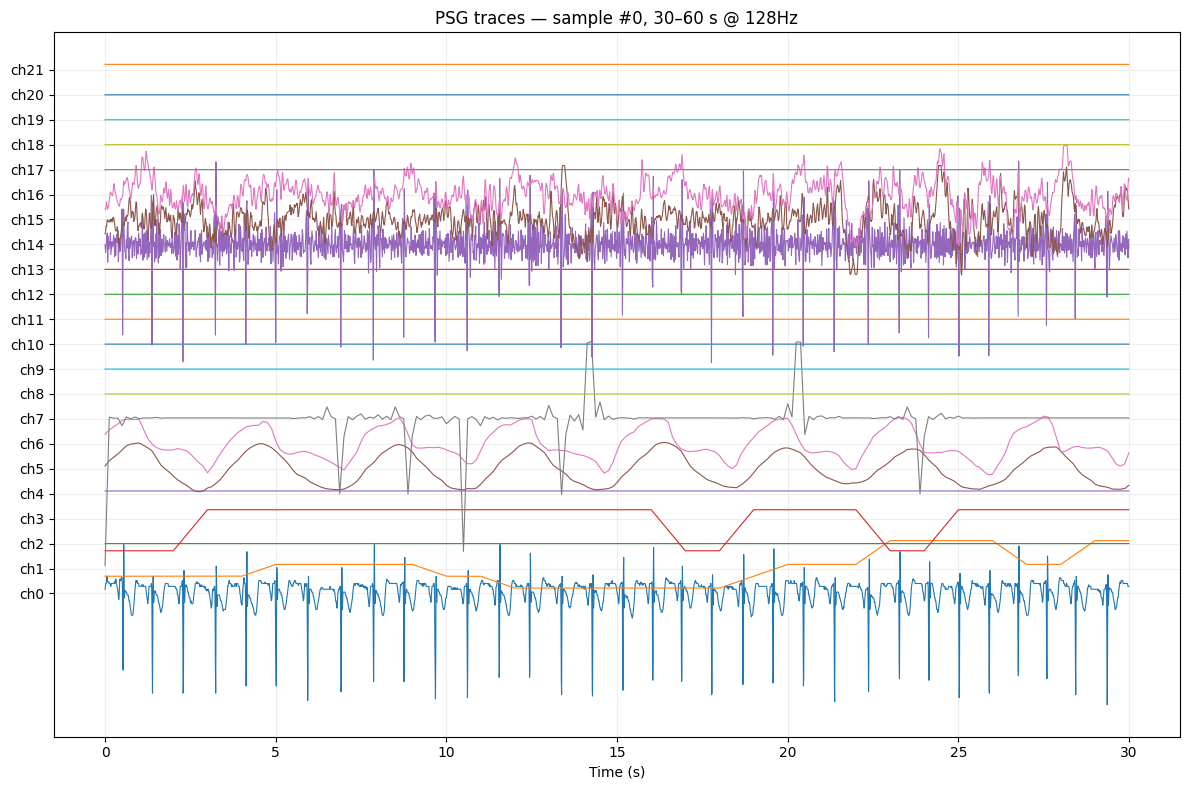

In [14]:
psg = batch['psg']  # (16, 22, 38400)

# 1) 看一条样本的前 30s，多通道叠加
plot_psg_traces(psg, sr=128, batch_idx=0, secs=(30, 60), channels=range(22), normalize="z", offset=True)

# # 2) 看同一条样本第 5~35s，只画前 8 个通道
# plot_psg_traces(psg, sr=128, batch_idx=0, secs=(5, 35), channels=range(8))

# # # 3) 画频谱：第 0 条样本、第 0 通道、0~30s
# # plot_psg_spectrogram(psg, sr=128, batch_idx=0, ch=0, secs=(0, 30))


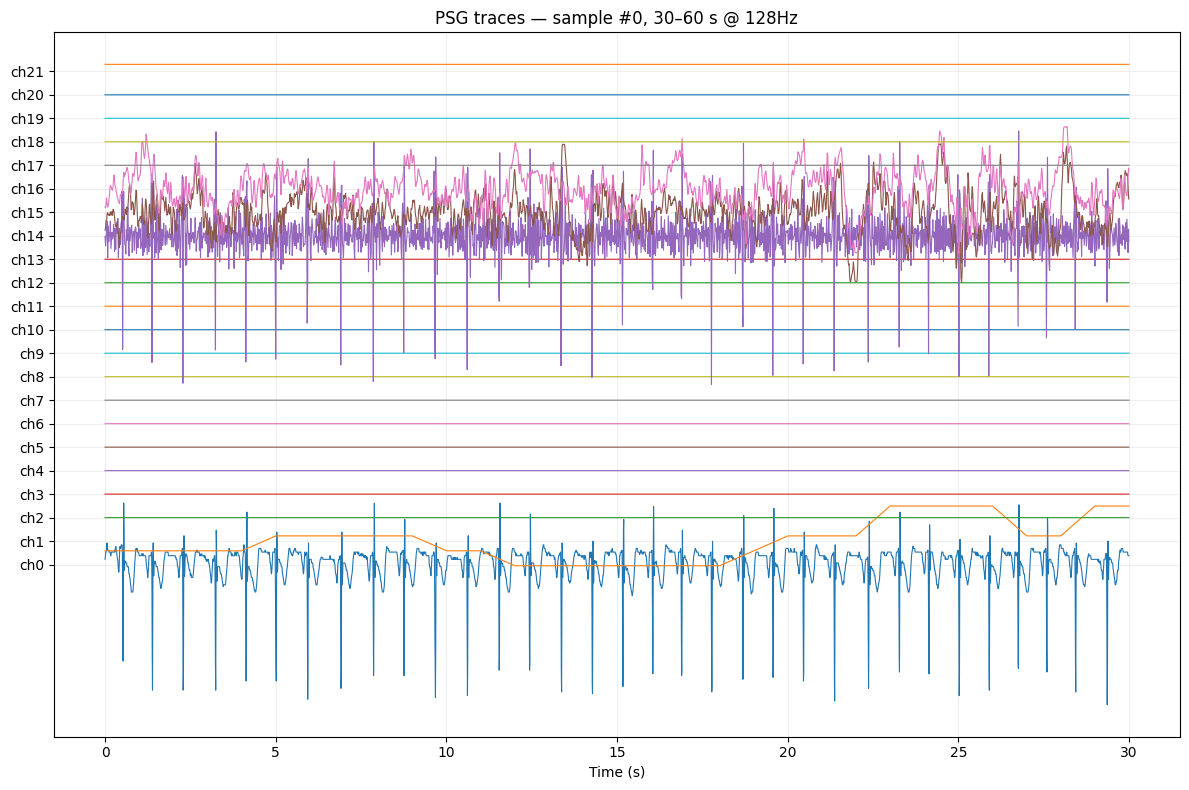

In [15]:
psg = batch['psg']  # (16, 22, 38400)
psg[:,3:10,:]=0
# 1) 看一条样本的前 30s，多通道叠加
plot_psg_traces(psg, sr=128, batch_idx=0, secs=(30, 60), channels=range(22), normalize="z", offset=True)

# # 2) 看同一条样本第 5~35s，只画前 8 个通道
# plot_psg_traces(psg, sr=128, batch_idx=0, secs=(5, 35), channels=range(8))

# # # 3) 画频谱：第 0 条样本、第 0 通道、0~30s
# # plot_psg_spectrogram(psg, sr=128, batch_idx=0, ch=0, secs=(0, 30))


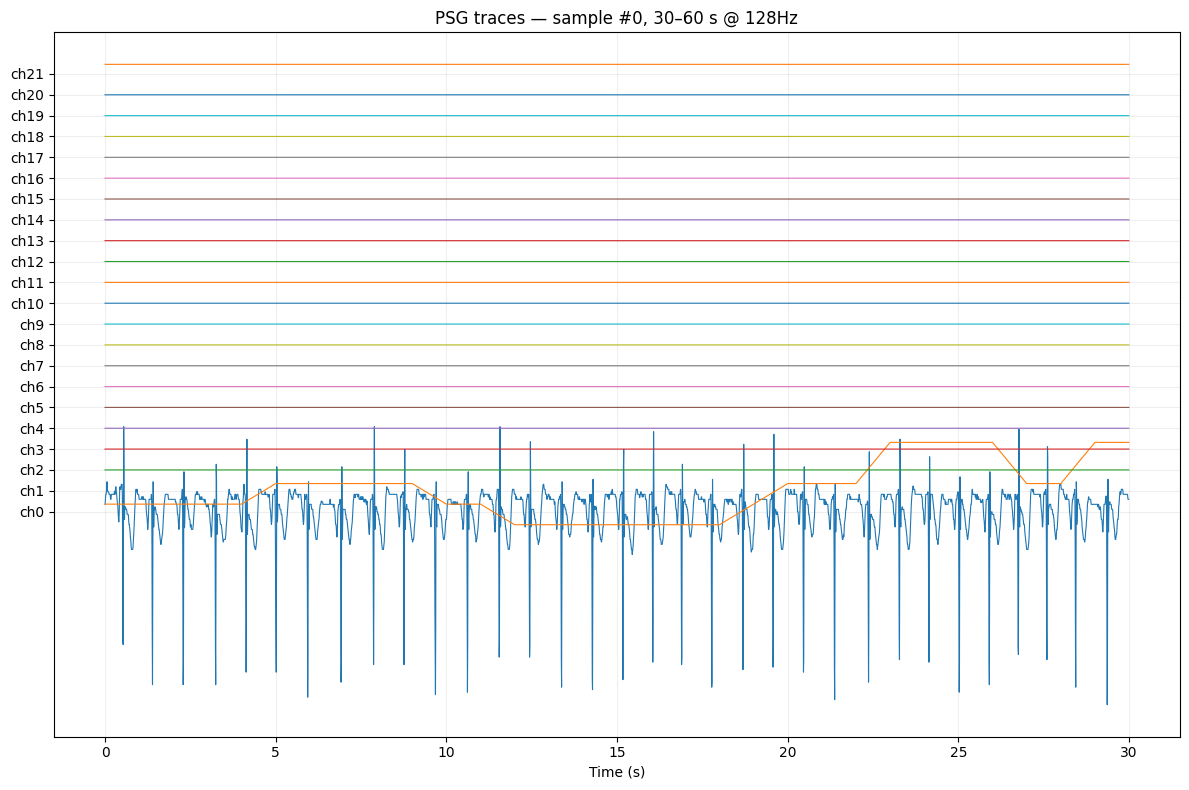

In [16]:
psg = batch['psg']  # (16, 22, 38400)
psg[:,13:20,:]=0
# 1) 看一条样本的前 30s，多通道叠加
plot_psg_traces(psg, sr=128, batch_idx=0, secs=(30, 60), channels=range(22), normalize="z", offset=True)

# # 2) 看同一条样本第 5~35s，只画前 8 个通道
# plot_psg_traces(psg, sr=128, batch_idx=0, secs=(5, 35), channels=range(8))

# # # 3) 画频谱：第 0 条样本、第 0 通道、0~30s
# # plot_psg_spectrogram(psg, sr=128, batch_idx=0, ch=0, secs=(0, 30))
